## Connet to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set all the directories

In [ ]:
HOME_DIR = "/content/drive/MyDrive/data/train/"

# Folder path for sub-images
SUB_DIR = "/content/drive/MyDrive/data/train/sub_img/"
# Trained Model(parameters) path
MODEL_DIR = "/content/drive/MyDrive/data/model/"

### Import Libraries and Modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
import json
import cv2
import h5py
#import imageio
from IPython.display import Image

import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    MaxPooling2D,
    UpSampling2D,
    concatenate
)
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#from tensorflow.compat.v1.logging import INFO, set_verbosity

#set_verbosity(INFO)

K.set_image_data_format("channels_first")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Check runtime type (Important)

In [ ]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')
if len(tf.config.list_physical_devices('GPU')) == 0 :
  print("No GPU enable, check the runtime type!!!")

Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Encoder(DownSampling) Block

In [ ]:
def conv_block(inputs = None, n_filters = 32, dropout_prob = 0, max_pooling = True):

  """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
  """

  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation = 'relu',
                padding = 'same',
                kernel_initializer = 'he_normal')(inputs)

  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation = 'relu',
                padding = 'same',
                kernel_initializer = 'he_normal')(conv)

  # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
  if dropout_prob > 0:
    conv = Dropout(dropout_prob)(conv)

  # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
  if max_pooling:
    next_layer = MaxPooling2D(2, strides = 2)(conv)

  else:
    next_layer = conv

  skip_connection = conv

  return next_layer, skip_connection


### Decoder(UpSampling) Block

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
  """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
  """

    ### START CODE HERE
  up = Conv2DTranspose(filters = n_filters,
                       kernel_size = 3,
                       strides=2,
                       padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
  #merge = concatenate([up, contractive_input], axis=3)
  merge = concatenate([up, contractive_input], axis=1)
  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(merge)
  conv = Conv2D(filters = n_filters,
                kernel_size = 3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv)

  return conv

### UNET Model

In [ ]:
def unet_model(input_size=(256, 256, 1), n_filters=32, n_classes=1):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # Chain the first element of the output of each block to be the input of the next conv_block.
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False)

    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer.
    # At each step, use half the number of filters of the previous block
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    #conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    conv10 = Conv2D(filters = 1, kernel_size = 1, data_format = 'channels_first',activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

### [Edit] Model Compile and Summary

Please make sure you understand the parameters/method before you change it.

In [ ]:
# Size of input sub_image
input_size=(1, 256, 256) # in our case = (1, 256, 256)
# Initial number of filter.
n_filters=32 # Can be 32 or 64, or try another number.
# Number of classes
n_classes=1 # in our case = 1

unet= unet_model(input_size=input_size, n_filters=n_filters, n_classes=n_classes)

In [ ]:
unet.compile(optimizer='adam', # This method can be changed
              loss='binary_crossentropy', # This method can be changed
              metrics=['BinaryIoU']) # This method can be changed
unet.summary()

## [Edit] Load model and continue Training (Optional)

If training from the very beginning, skip this block

In [ ]:
# Choose the model under the folder
filename = "Model_200epochs.h5"

from tensorflow.keras.models import load_model
model = MODEL_DIR + filename
print(f"Choosen Load Model is: {model}")
UNET_MODEL =unet.load_weights(model)

### Load the Dataset

This might take few minutes to complete

In [ ]:
# Load X_series and y_series from files

X_series = np.load(os.path.join(HOME_DIR, 'X_series.npy'))
y_series = np.load(os.path.join(HOME_DIR, 'y_series.npy'))

## [Edit] Get the Training Set and Validation Set (optional)

The split of training set and validation set is recommanded but optional.

In [ ]:
# Define the ratio of Training Set vs Validation Set
split_ratio = 0.072 # Normaly 0.1~0.3 depends on the richness of dataset



from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_series, y_series, test_size = split_ratio, random_state =39)
print(f"The shape of training set is: {X_train.shape} (Number, channel, width(x-axis pixel), height(y-axis pixel))") #訓練集
print(f"The shape of validation set is: {X_valid.shape} (Number, channel, width(x-axis pixel), height(y-axis pixel))")  #驗證集

The shape of training set is: (2000, 1, 256, 256) (Number, channel, width(x-axis pixel), height(y-axis pixel))
The shape of validation set is: (156, 1, 256, 256) (Number, channel, width(x-axis pixel), height(y-axis pixel))


## [Edit] Set the Training Parameters:

In [ ]:
# Set the size of batch for each input
batch_size = 8 # Can chagne to 1,2,4,16 or another nubmer

# Set the number of epochs
n_epochs = 10 #迭代

# Set the saving period(unit: epoch)
save_period = 5 # each number of trained epochs the model will save the weights(model) automatically

## 'steps_per_epoch' was removed due to potential bug in tensorflow,
## consider add it back in the future if the bug is fixed.
#steps_per_epoch=X_train.shape[0] // batch_size

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,  LearningRateScheduler

# set the filename pattern for the model weights
filename = "Model_weights_-{epoch:02d}.h5"

# set the full filepath for the model weights
filepath = os.path.join(MODEL_DIR, filename)
print(f"Directory of the saved model: {MODEL_DIR}")

# 建立 ModelCheckpoint 回調函數
# 訓練模型時使用 callbacks 參數指定 ModelCheckpoint 回調函數
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    period=save_period
)

Directory of the saved model: /content/drive/MyDrive/data/model/


## [Edit] Start/Continue the Training

In [ ]:
history = unet.fit(
        x=X_train,
        y=y_train,
        #steps_per_epoch=steps_per_epoch,
        shuffle = True,
        batch_size = batch_size,
        validation_data = (X_valid, y_valid),
        epochs = n_epochs,
        use_multiprocessing = True,
        verbose = 1,
        callbacks=[checkpoint]
        )

Epoch 1/10
250/250 [==============================] - 74s 200ms/step - loss: 0.3262 - binary_io_u: 0.6672 - val_loss: 0.2489 - val_binary_io_u: 0.7340
Epoch 2/10
250/250 [==============================] - 45s 179ms/step - loss: 0.2526 - binary_io_u: 0.7278 - val_loss: 0.2391 - val_binary_io_u: 0.7438
Epoch 3/10
250/250 [==============================] - 44s 177ms/step - loss: 0.3652 - binary_io_u: 0.6103 - val_loss: 0.2905 - val_binary_io_u: 0.7021
Epoch 4/10
250/250 [==============================] - 44s 175ms/step - loss: 0.2646 - binary_io_u: 0.7169 - val_loss: 0.2458 - val_binary_io_u: 0.7356
Epoch 5/10
250/250 [==============================] - ETA: 0s - loss: 0.2502 - binary_io_u: 0.7284
Epoch 5: saving model to /content/drive/MyDrive/data/model/Model_weights_-05.h5
250/250 [==============================] - 44s 177ms/step - loss: 0.2502 - binary_io_u: 0.7284 - val_loss: 0.2431 - val_binary_io_u: 0.7257
Epoch 6/10
250/250 [==============================] - 44s 175ms/step - loss: 

## [Edit] Save the trained Model/Weights

In [ ]:
# Define the model name
model_name = "try2_10epochs.h5" #end with .h5 as filetype

unet.save_weights(MODEL_DIR + model_name)

print(f"Model saved to {MODEL_DIR}")

## Plot the training history

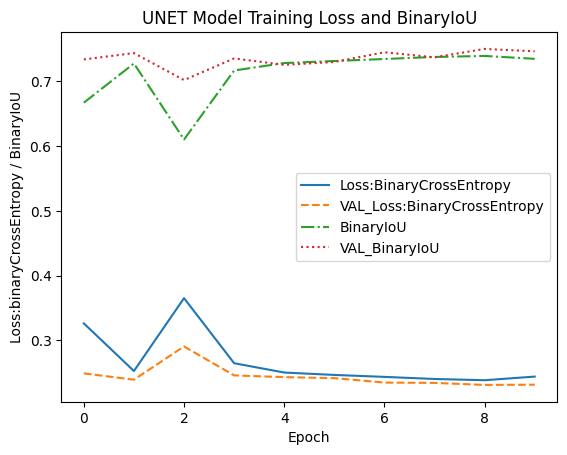

In [ ]:

# Plot the training loss and accuracy
plt.plot(history.history['loss'],)
plt.plot(history.history['val_loss'],'--')
plt.plot(history.history['binary_io_u'],'-.')
plt.plot(history.history['val_binary_io_u'],':')

# Add labels and title
plt.title('UNET Model Training Loss and BinaryIoU')
plt.xlabel('Epoch')
plt.ylabel('Loss:binaryCrossEntropy / BinaryIoU')
#plt.legend(['Loss', 'Val_Loss', 'Dice Coefficient', 'Val_Dice Coefficient'], loc='center right')
plt.legend(['Loss:BinaryCrossEntropy','VAL_Loss:BinaryCrossEntropy','BinaryIoU','VAL_BinaryIoU'], loc='center right')

# Show the plot
plt.show()

## Save the training history (optional)

Only execute this block for saving training history data

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# Save as json:
hist_json_file = 'history.json'
with open(MODEL_DIR + hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# Save as csv:
hist_csv_file = 'history.csv'
with open(MODEL_DIR + hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

print(f"Training history data saved to {MODEL_DIR}")